#Connect the drive

In [242]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/Multicore/Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Multicore/Project


#Imports

In [243]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.metrics import mean_absolute_error

#Graphs of Features with Execution Time for each thread

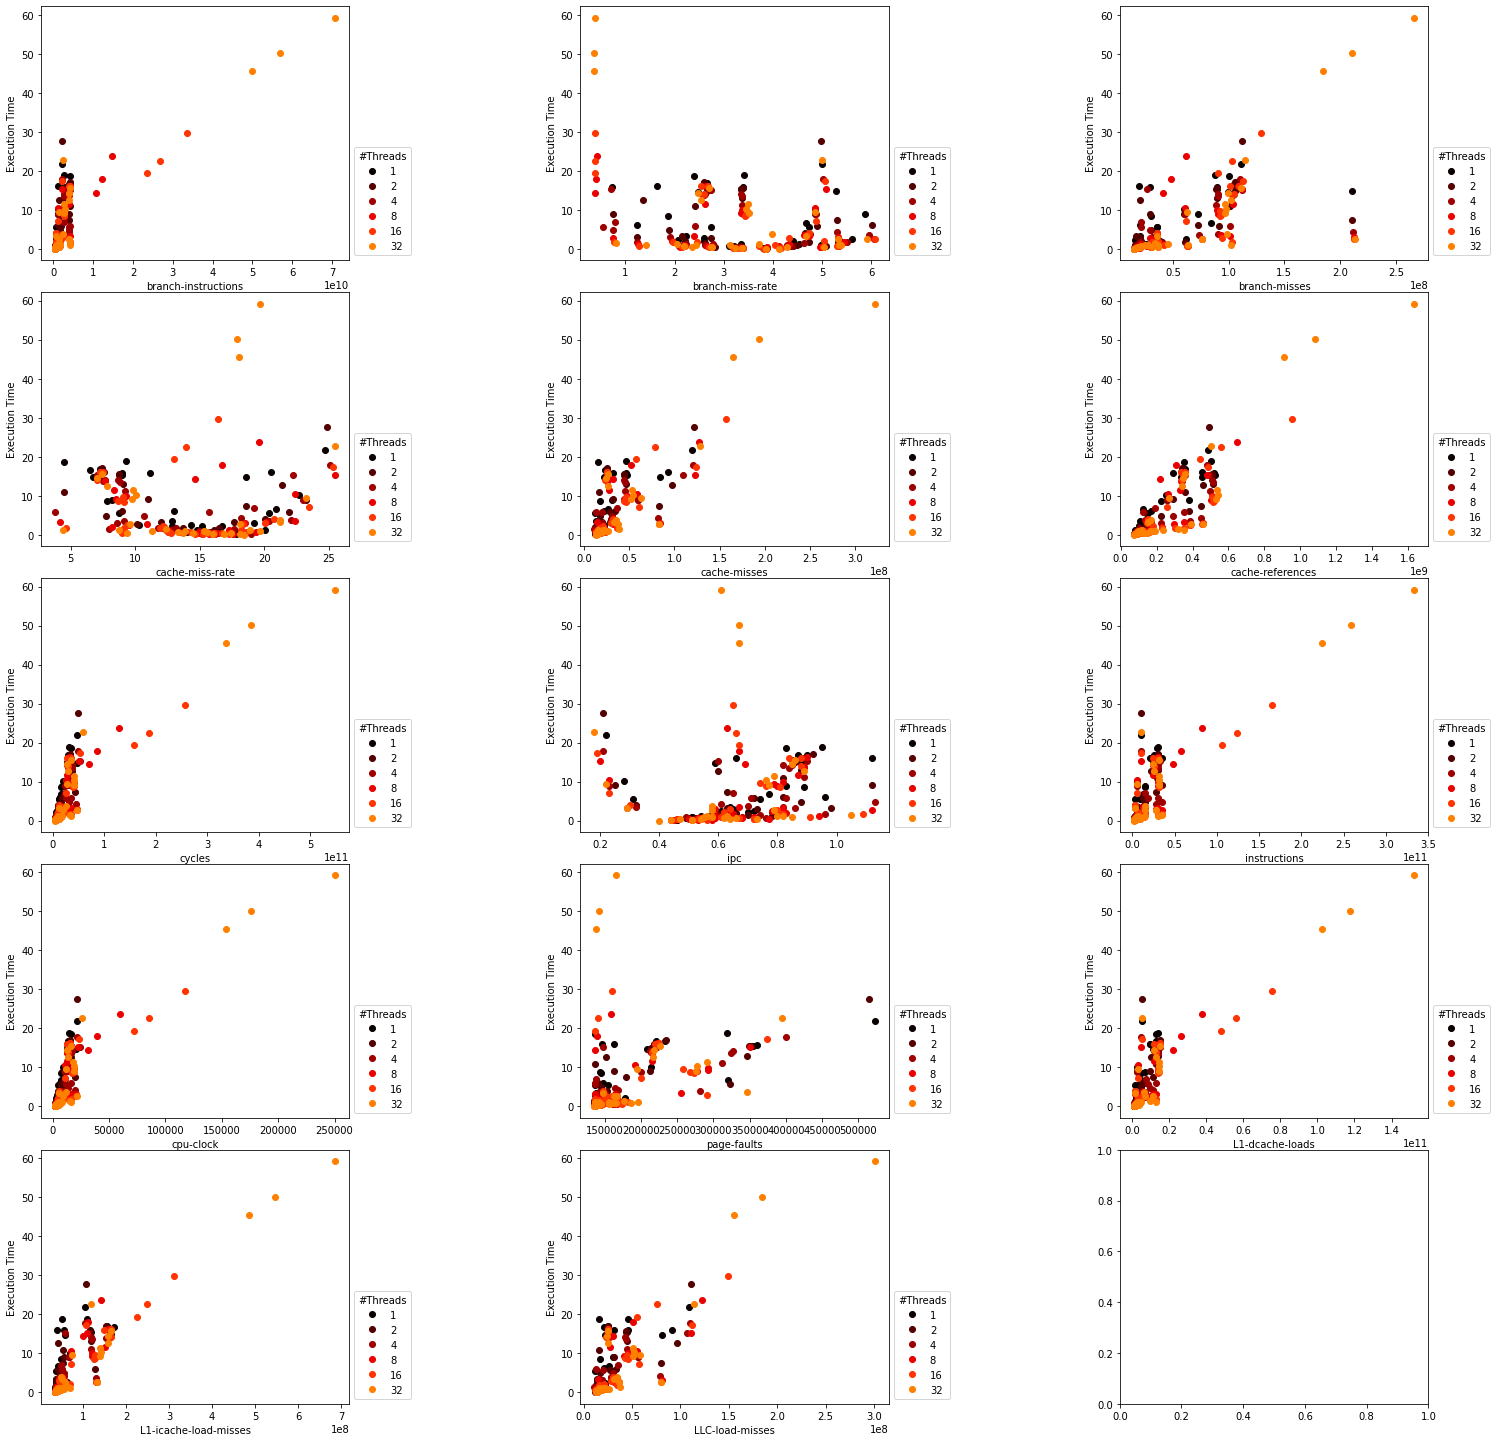

In [250]:
data = pd.read_csv('final_data.csv')  

no_of_threads = [1,2,4,8,16,32]
columns_name_not_iter = ['app_name','app_size','mode','speedup','execution_time','num_threads']

y_axis_data = data[['num_threads','execution_time']]
jet = plt.get_cmap('hot')

figure, axs = plt.subplots(5, 3, figsize=(20, 20))
axs = axs.flatten()

figure.tight_layout(w_pad=20.0)

i = 0
#Draw the scatter plot for each thread
for (columnName, columnData) in data.iteritems():
    if columnName not in columns_name_not_iter:
        colors = iter(jet(np.linspace(0,1,10)))
        col_data_t = data[['num_threads', columnName]]
        for t in no_of_threads:
            col_data = col_data_t.loc[col_data_t['num_threads'] == t][columnName] 
            col_y_axis_data = y_axis_data.loc[y_axis_data['num_threads'] == t]['execution_time'] 
            axs[i].plot(col_data, col_y_axis_data, 'o', color=next(colors), label=t)
            axs[i].set(xlabel=columnName, ylabel='Execution Time')
            axs[i].legend(bbox_to_anchor=(1, 0), loc='lower left', ncol=1, title = "#Threads")
        i = i+1



#Task is to normalize data

#Data Cleaning

In [244]:
data = pd.read_csv('final_data.csv') 

#Filter out the data which has just one thread they are not going to contribute to the learning
data = data.loc[data['num_threads'] != 1]

#First get the sppedup data
speedup_data = data['speedup']

#Drop the columns which have alphabetical data
data = data.drop(columns=['speedup','app_name','app_size','execution_time','mode'])

#Convert the data to numpy array
X = data.to_numpy()

#Convert the speedup to numpy array
Y = speedup_data.to_numpy()

# Random seed value for shuffling
seed = 5

# 20% test data and 80% training data
test_size = 0.2

# Prepare testing and training data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#Models

##Random Forest

Random forest validation MAE:  0.6368900614111771


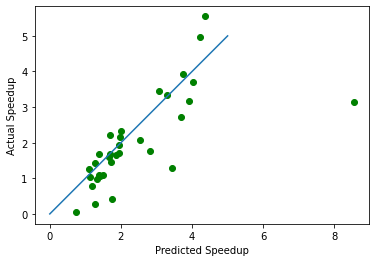

In [245]:
# Random forest Regression
model = RandomForestRegressor()
model.fit(X_train,Y_train)

predicted_exe_time = model.predict(X_test)
MAE = mae(Y_test , predicted_exe_time)
print('Random forest validation MAE: ', MAE)
plt.scatter(predicted_exe_time, Y_test, c="g")
plt.plot(range(int(max(Y_test)) + 1))
plt.xlabel('Predicted Speedup')
plt.ylabel('Actual Speedup')
plt.show()

##Gradient Boosting

###Hyperparameter Tuning for Gradient Boosted Regression
1. Set n_estimators as high as possible
2. Tune hyperparameteres via grid search
3. Finally, set n_estimators even higher and tune learning rate

### Tune the hyerparameters on our training data

In [246]:
n_estimator = 3000

param_grid = {
    'learning_rate': [0.01, 0.015 ,0.02, 0.025 ,0.03],
    'max_depth' : [4, 6]
}

estimator = GradientBoostingRegressor(n_estimators=no_of_estimators)
gs_cv = GridSearchCV(estimator, param_grid).fit(X_train, Y_train)

print(gs_cv.best_params_)

{'learning_rate': 0.02, 'max_depth': 6}


###Retune the learning rate

In [247]:
no_of_estimators = 3000

param_grid = {
    'learning_rate': [0.01, 0.015 ,0.02, 0.025 ,0.03, 0.035, 0.040, 0.045, 0.050]
}

estimator = GradientBoostingRegressor(n_estimators=no_of_estimators)
gs_cv = GridSearchCV(estimator, param_grid).fit(X_train, y_train)

print(gs_cv.best_params_)

{'learning_rate': 0.035}


###Use the learning rate derived in the previous step to train the model again

In [248]:
tune_estimator = GradientBoostingRegressor(n_estimators=3000, max_depth=6, learning_rate=0.025).fit(X_train,y_train)
predicted_speedup = tune_estimator.predict(X_test)

### Plot the graph and Mean squared error

Gradient Bossted Regressor validation MAE:  0.44650921033176066


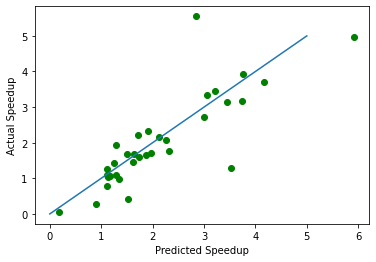

In [249]:
MAE = mae(y_test, predicted_speedup)
print('Gradient Bossted Regressor validation MAE: ', MAE)
plt.scatter(predicted_speedup, y_test, c="g")
plt.plot(range(int(max(y_test)) + 1))
plt.xlabel('Predicted Speedup')
plt.ylabel('Actual Speedup')
plt.show()